# Logistic regression for supervised classification

Logistic regression aims at solving the following empirical risk minimization problem
  $$ \min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum_{i=1}^n \ell(\langle {X_i},{x} \rangle,y_i)  $$
where the logistic loss reads
  $$ \ell(s,v) = \log( 1+\exp(-s v) ) . $$
$X \in \mathbb{R}^{n \times d}$ is the feature matrix and $y \in \{-1,+1\}^n$ is the label vector.

The goal of the notebook is to apply Stochastic Gradient Descent and its variance reduced variants (SAGA and SVRG) to solve the above problem.

We refer to the course and tutorials (TD) for:
* background and more details about the derivations of the logistic classification risk and its gradient. In particular, $f$ is convex and $L$-smooth whose gradient is also bounded. $L$ can be bounded by $\Vert X \Vert^2/4$ though this bound is too crude in practice.  
* SGD and its variance reduced variants and their theoretical convergence guarantees.

In [2]:
%reset -f
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
%reload_ext autoreload
%autoreload 2

### Utility functions

In [3]:
#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]

### Load dataset
---------------
We load a subset of the <http://osmot.cs.cornell.edu/kddcup/datasets.html
dataset Quantum Physics Dataset>
of $n=10000$ features in dimension $78$. The goal in this task is to learn a classification rule that differentiates between two types of particles generated in high energy collider experiments.



Load the dataset.
Randomly permute it.
Separate the features $X$ from the labels $y$ to predict.

In [4]:
from scipy import io
U = io.loadmat('data-quantum')
A = U['A']
A = A[np.random.permutation(A.shape[0]),:]
X = A[:,0:-1]
y = A[:,-1]

Set the classes indexes to be $\{-1,+1\}$.

In [5]:
y = 2*y-1
# y must be a column vector
y = MakeCol(y)

Remove empty features, normalize $X$.

In [6]:
I = find( np.abs(X).mean(axis=0)>1e-1 )
X = X[:,I]
# normalize
X = X-X.mean(axis=0)
X = X/X.std(axis=0)

$n$ is the number of samples, $d$ is the dimensionality of the features,

In [7]:
[n,d] = X.shape
print(n,d)

10000 46


Compute PCA main axes for display.

<IPython.core.display.Javascript object>


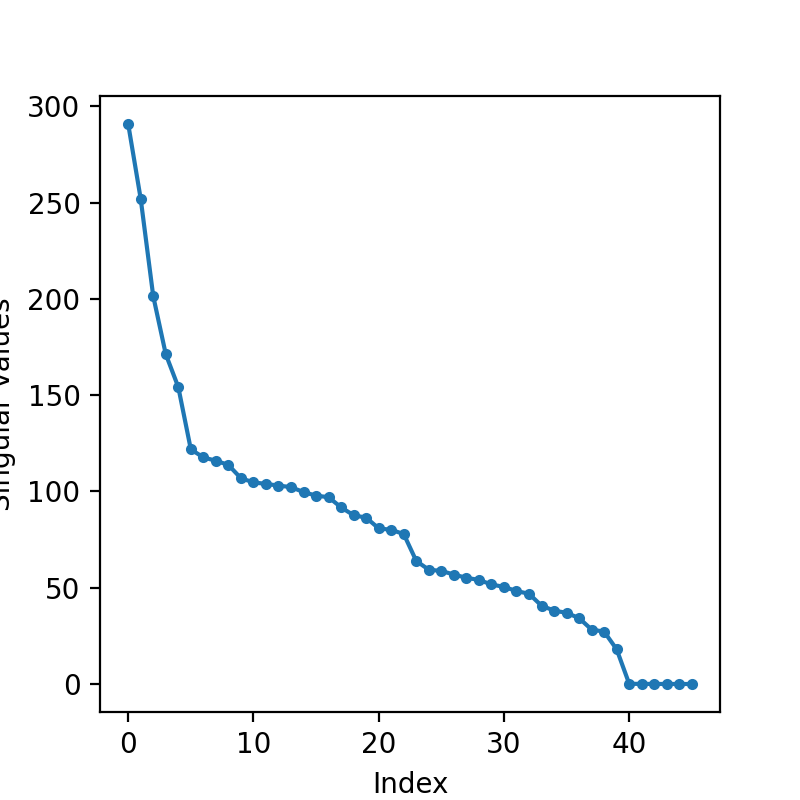

In [8]:
U, s, V = np.linalg.svd(X)
Xr = X.dot( V.transpose() )
# display the decay of eigenvalues
plt.figure(figsize=(4,4))
plt.plot(s, '.-');
plt.xlabel('Index');
plt.ylabel('Singular values');
plt.show()

Plot the classes in 2D and then 3D (2 and 3 directions explaining most data variance).

<IPython.core.display.Javascript object>


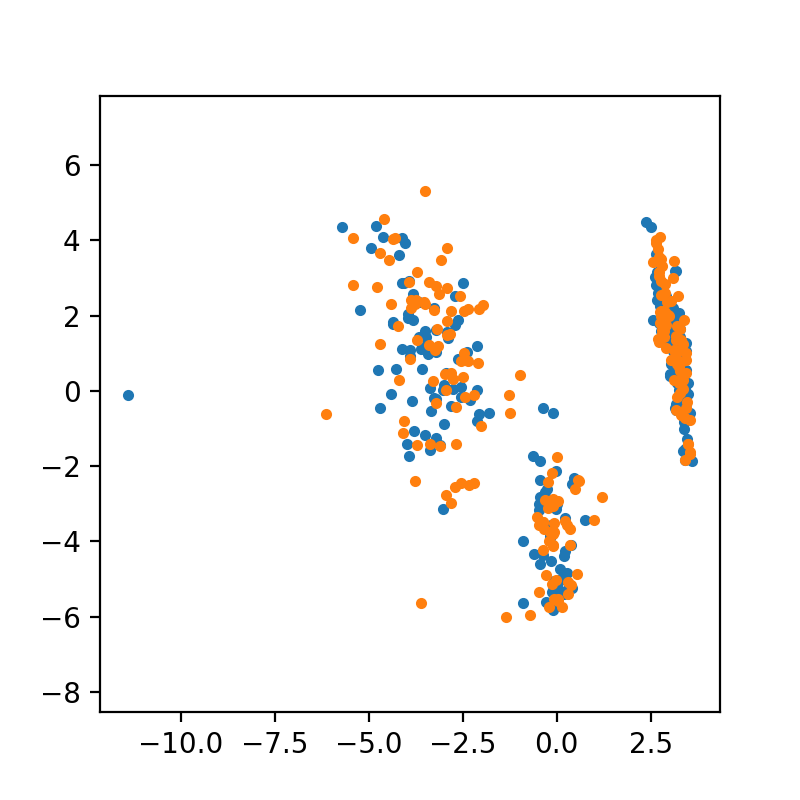

In [9]:
plt.figure(figsize=(4,4))
I = find(y==-1)
J = find(y==+1)
plt.plot(Xr[I[0:200],0], Xr[I[0:200],1], '.')
plt.plot(Xr[J[0:200],0], Xr[J[0:200],1], '.')
plt.axis('equal');
plt.show()

<IPython.core.display.Javascript object>


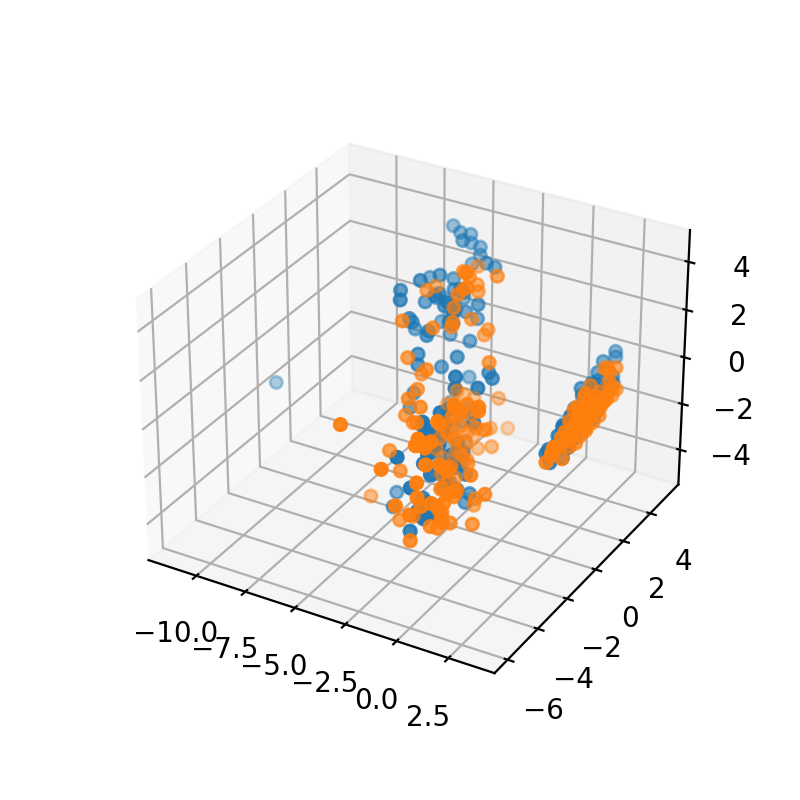

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
plt.clf
ax.scatter(Xr[I[0:200],0], Xr[I[0:200],1], Xr[I[0:200],2], '.')
ax.scatter(Xr[J[0:200],0], Xr[J[0:200],1], Xr[J[0:200],2], '.')
plt.axis('tight');
plt.show()

# Gradient Descent 

We first test the usual gradient descent (GD) on the problem of
supervised logistic classification. This corresponds to the scheme
$$ 
x_{k+1} = x_k - \gamma_k \nabla f(x_k) , \quad where \quad \nabla f(x) = -\frac{1}{n} \sum_{i=1}^n y_i X_i \theta(y_i \langle X_i,x \rangle), \theta(s) = 1 / (1+e^{s}) .
$$

Functions to compute $f(x)$ and its gradient $\nabla f(x)$.

In [11]:
def l(s,y):  return 1/n * np.sum( np.log( 1 + np.exp(-s*y) ) )
def f(x,X,y): return l(X.dot(x),y)
def theta(s): return 1 / (1+np.exp(s))
def nablal(s,y): return - 1/n * y * theta(s * y)
def nablaf(x,X,y): return X.transpose().dot( nablal(X.dot(x),y) )

## Question 1

* ### Implement GD. 
* ### Choose $\gamma=0.75$, run GD and plot the function $f$ as a function of the iteration counter. 

In [2]:
## Insert your code here.

# Accelerated Gradient Descent 

We now test the accelerated gradient descent (AGD) on the problem of
supervised logistic classification. This corresponds to the scheme
$$ 
x_{k+1} = z_k - \gamma_k \nabla f(z_k) , \quad where \quad z_k = x_k + (1-\alpha/k)(x_k-x_{k-1}) , \quad \alpha \geq 3 .
$$

## Question 2

* ### Implement AGD. 
* ### Choose $\gamma=0.75$ and $\alpha \geq 3$, run AGD, plot the function $f$ as a function of the iteration counter an compare to GD.

In [ ]:
## Insert your code here.

# Stochastic Gradient Descent (SGD)

As any empirical risk minimization procedure, the
logistic classification minimization problem can be written as
$$ 
\min_{x \in \mathbb{R^d}} f(x) = \frac{1}{n} \sum_{i=1}^n f_i(x) \quad where \quad f_i(x) = \ell(\langle {X_i},{x}\rangle,y_i). 
$$

The cost of omputing $\nabla f(x)$ is $O(nd)$ which is prohibitive for very large $n$.

Stochastic Gradient Descent (SGD) exploits the finite sume structure to reduce this cost by rather running a scheme of the form
  $$ x_{k+1} = x_k - \gamma_k \nabla f_{i_k}(x_k) $$
where, for each iteration index $k$, $i_k$ is drawn uniformly at random in $  \{1,\ldots,n\} $.

$\nabla f_{i}(x)$ reads
$$ 
\nabla f_{i}(x) = - y_i X_i \theta(y_i \langle {X_i},{x}\rangle) .
$$
The cost per iteration is that of computing $\nabla f_{i}(x)$ which is $O(d)$. SGD is thus advantageous when $n$ is very large, and one cannot afford to do several passes through the data. In some situation, SGD can provide
accurate results even with $k \ll n$, exploiting redundancy between the data samples.

Function to compute $\nabla f_i(x)$.

In [12]:
def nablafi(x,i,X,y): return MakeCol( -y[i] * X[i,:].transpose() * theta( y[i] * (X[i,:].dot(x)) ) )

As seen in the course, a crucial question is the choice of step size schedule $\gamma_k$. It
must tends to 0 in order to cancel the noise induced on the gradient by
the stochastic sampling. But it should not go too fast to zero in order
for the method to keep converging.

As seen in the course, a typical schedule that ensures both properties is to have asymptically $\gamma_k \sim k^{-1/2}$ for
$k \rightarrow +\infty$. We thus propose to use
$$ 
\gamma_k = \frac{\gamma_0}{\sqrt{1 + k/k_0}} 
$$
where $k_0$ indicates roughly the number of iterations serving as a "warmup" phase. As seen in the course, this entails an ergodic convergence rate 
$$ 
\mathbb{E}(f(\bar{x}_k) ) - \min f) = O\left( \frac{\log(k+1)}{\sqrt{k+1}} \right), 
$$
where $\mathbb{E}$ indicates an expectation with respect to the i.i.d. sampling performed at each iteration, and $\bar{x}_k=\sum_{i=0}^k\gamma_i x_i/\sum_{j=0}^k \gamma_j$. In fact, this can be improved by taking the average $\bar{x}_k=\frac{1}{k+1}\sum_{i=0}^k x_i$. Note that using a moving average, one does not have to store all the iterates to compute the mean iterate, e.g. for the mean at iteration $k$,
$$ 
\bar{x}_{k} = (x_k + k\bar{x}_{k-1})/(k+1).  
$$

Implement SGD.

In [13]:
k0 = 1
gamma0 = 0.75 # Should be in ]0,1/L], L being the gradient Lipschitz constant.
niterSGD = 100000

## Question 3

* ### Implement SGD with the two types of averaging above. 
* ### Run SGD and plot the function $f$ as a function of the iteration counter. 
* ### Compare to Gradient Descent and discuss. For the comparison to make sense, $f$ for SGD must be displayed at multiples of $n$. 

In [14]:
## Insert your code here.

# Variance reduced methods

Though very versatile, the issue with SGD with varying step-size is its slow convergence. We now switch to exploiting the finite sum structure and using variance reduced methods that allow constant step-size.

### Stochastic Averaged Gradient method (SAG)
For problem size $n$ where the dataset (of size $n \times d$) can
fully fit into memory, it is possible to improve the SGD method by storing and averaging the previous estimates of the gradients of each $f_i$. This averaging idea is behind SAG which can also be seen as a variance reduced method, though biased (see the course).


SAG stores all the previously computed gradient in $(G^i)_{i=1}^n $, which necessitates $O(nd)$ memory storage. The iterates are defined by using $g$, a (biased) estimate of the batch gradient, which is progressively enhanced reducing its variance along the iterates. The SAG algorithm reads
$$ 
\begin{cases}
i_k \sim \mathrm{Uniform}(\{0,\cdots,n-1\}), \\
h \leftarrow \nabla f_{i_k}(x_k), \\
g  \leftarrow g + h - G[:,i_k], \\
x_{k+1} = x_k - \gamma g /n ,  \\
G[:,i_k] \leftarrow h . 
\end{cases}
$$
In contrast to SGD, SAG uses a fixed step-size $\gamma$. To ensure convergence, the step-size is chosen as $\gamma=\eta/L$, where $\eta \in ]0,1]$ is small enough. 

SGA has ergodic $O(n/k)$ convergence rate, which is the same rate as GD (after the same number of passes on data) and much better than SGD.

## Question 4

* ### Implement SAG. 
* ### Run SAG with $\gamma = 0.002$ and plot the function $f$ as a function of the iteration counter. 
* ### Compare to Gradient Descent and SGD. For the comparison to make sense, $f$ for SAG and SGD must be displayed at multiples of $n$. 
* ### Discuss and comment on the pros and cons of each algorithm.

In [15]:
## Insert your code here.

## Stochastic Variance Reduced Gradient method (SVRG)
For problem size $n$ where the dataset (of size $n \times d$) CANNOT fully fit into memory, it is possible to improve the SAG method by storing the previous gradients. SVRG is a variance reduced method which does not necessitate to store the previous gradients but must compute the full gradient regularly (see the course).

The SVRG algorithm with minibatch size $1$ reads
\begin{align*}
&\text{for each epoch $k$} \\
&\qquad \tilde{g} \to \frac{1}{n}\sum_{i=1}^n \nabla f_i(\tilde{x}) \\
&\qquad \text{for each $j$ in epoch length} \\
&\qquad\quad i_k \sim \mathrm{Uniform}(\{0,\cdots,n-1\}), \\
&\qquad\quad h \leftarrow \nabla f_{i_k}(x_k), \tilde{h} \leftarrow \nabla f_{i_k}(\tilde{x}), \\
&\qquad\quad g  \leftarrow \tilde{g} + h - \tilde{h}, \\
&\qquad\quad x_{j+1} = x_j - \gamma g . \\
&\qquad \text{endfor} \\
&\qquad \tilde{x}  \leftarrow x \\
&\text{endfor}
\end{align*}

Again, similarly tp SAG, SVRG uses a fixed step-size $\gamma$. To ensure convergence, the step-size is chosen as $\gamma=\eta/L$, where $\eta \in ]0,1]$ is small enough ($\eta \leq 1/(2+3~\text{epoch_length})$, see course). 

SVRG has ergodic $O(1/(k~\text{epoch_length})$ convergence rate, which is again much better than SGD. Unlike SAG, SVRG does not require gradient storage and the computational cost per-iteration is $O(d)$. However, it requires full gradient computation at each epoch.

## Question 5

* ### Implement SVRG. 
* ### Run SVRG with $\gamma = 3/\text{epoch length}$ and plot the function $f$ as a function of the iteration counter. 
* ### Compare to Gradient Descent, SGD and SAG. For the comparison to make sense, $f$ for SVRG, SAG and SGD must be displayed at multiples of $n$. 
* ### Discuss and comment on the pros and cons of each algorithm.

In [16]:
nepochs = 100
epochlen= 50

In [17]:
## Insert your code here.